# Bias Correction of Climate Model Output over Antarctica using a Bayesian Hierarchical Model and Gaussian Processes

## Introduction

- This notebook focuses on demonstrating some of the key components of a novel approach to bias correcting climate model output using in-situ observations. The approach utilises Gaussian Processes (GPs) and a Bayesian hierarchical framework. Near-surface temperature data is used from automatic weather stations (AWS) over Antarctica to correct an Antarctic-wide climate model simulation.  

- The following paper details the methodology as applied to simulated 1D examples: [Bayesian hierarchical model for bias-correcting climate models](https://doi.org/10.5194/gmd-17-5733-2024). Meanwhile, the work on applying this to real-world surface climatology over Antarctica is ongoing and the code is being developed at the following repository: [Bias Correction Application](https://github.com/Jez-Carter/Bias_Correction_Application.git). Necessary data for this notebook can be found and downloaded from the /walkthrough_tutorial/tutorial_data folder of the repository. 

- Specific mention is given to the Python packages Xarray, Numpryo and TinyGP utilised in this tutorial. Xarray provides a nice way of handling the multidimension data from climate models. Numpyro provides a nice probabilistic programming language for Bayesian statistics. TinyGP provides a nice way of working with and defining Gaussian Processes, also integrating with Numpyro, both of which are built ontop of Jax.    



- The climate model data is available from download from this DOI: https://doi.org/10.5281/zenodo.6367849. While the AWS is available here: https://doi.org/10.48567/key7-ch19. 
- Bias is here defined with respect to the parameters of the PDF for the time series at each location. The AWS output is considered unbiased. The goal is to estimate the unbiased parameter values across the whole domain with an uncertainty, which can then be used to correct the climate model output. To do this generative models are constructed and the underlying spatial covariance structure of the data is considered through GPs.  

## Importing Required Libraries

In [6]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import geopandas as gpd
from scipy.spatial import distance
import matplotlib.pyplot as plt


## Data Exploration

The data for this tutorial is stored as NetCDF files. This is a common file format for climate model output and is handled well by the Xarray Python package, which can be thought of as a Pandas equivalent for efficient handling of multidimensional data. Xarray loads data as 'datasets' and 'dataarrays'. For specific tasks, such as summarising the data, these Python objects  can be transformed to Pandas 'dataframes'.  

In [2]:
# Loading Data
data_path = '/home/jez/Bias_Correction_Application/walkthrough_tutorial/tutorial_data/'

ds_aws = xr.open_dataset(f'{data_path}ds_aws.nc') # Automatic Weather Station Data
ds_climate = xr.open_dataset(f'{data_path}ds_climate.nc') # Climate Model Data

Xarray allows the data to be rendered and examined as nice interactive tables:

In [3]:
# Viewing the automatic weather station data
ds_aws

<xarray.Dataset> Size: 925kB
Dimensions:         (station: 219, t: 504)
Coordinates:
  * station         (station) <U22 19kB 'AGO Site' 'AGO-4' ... 'aws16' 'aws17'
    glat            (station) float64 2kB ...
    glon            (station) float64 2kB ...
    grid_latitude   (station) float64 2kB ...
    grid_longitude  (station) float64 2kB ...
    year            (t) float64 4kB ...
    month           (t) float64 4kB ...
  * t               (t) float64 4kB 1.0 2.0 3.0 4.0 ... 501.0 502.0 503.0 504.0
Data variables:
    latitude        (station) float64 2kB ...
    elevation       (station) float64 2kB ...
    temperature     (station, t) float64 883kB ...

In [4]:
# Viewing the climate model data
ds_climate

<xarray.Dataset> Size: 45MB
Dimensions:         (time: 456, grid_longitude: 126, grid_latitude: 98)
Coordinates:
  * grid_longitude  (grid_longitude) float64 1kB 152.4 152.9 ... 207.0 207.4
  * grid_latitude   (grid_latitude) float64 784B -21.39 -20.95 ... 20.84 21.29
  * time            (time) datetime64[ns] 4kB 1981-01-31 ... 2018-12-31
    month           (time) int64 4kB ...
    year            (time) int64 4kB ...
    glon            (grid_longitude, grid_latitude) float64 99kB ...
    glat            (grid_longitude, grid_latitude) float64 99kB ...
    t               (time) int64 4kB ...
Data variables:
    temperature     (time, grid_longitude, grid_latitude) float64 45MB ...
    elevation       (grid_longitude, grid_latitude) float64 99kB ...
    latitude        (grid_longitude, grid_latitude) float64 99kB ...

We'll start by plotting the location of the weather stations and the grid of the climate model output. 

```{admonition} Note: Missing Data
:class: note
Note that for plotting we use a specific rotated coordinate system (defined below). The 'glon' and 'glat' fields are in this coordinate system and it was created to get around issues assoicated with plotting the shapefile with longitude flipping between -180 to 180. 
```

In [ ]:
# Loading ice sheet shapefile 
icesheet_shapefile_path = '/home/jez/Bias_Correction_Application/walkthrough_tutorial/tutorial_data/icesheet_shapefile/icesheet.shp'
gdf_icesheet = gpd.read_file(icesheet_shapefile_path)

# Defining rotated coordinate system (glon,glat) and converting ice sheet shapefile to rotated coordinates
rotated_coord_system = ccrs.RotatedGeodetic(
    13.079999923706055,
    0.5199999809265137,
    central_rotated_longitude=180.0,
    globe=None,
)
gdf_icesheet_rotatedcoords = gdf_icesheet.to_crs(rotated_coord_system)

In [13]:
# Defining background map function
def background_map_rotatedcoords(ax):
    gdf_icesheet_rotatedcoords.boundary.plot(
        ax=ax,
        color='k',
        linewidth=0.3,
        alpha=0.4)
    ax.set_axis_off()

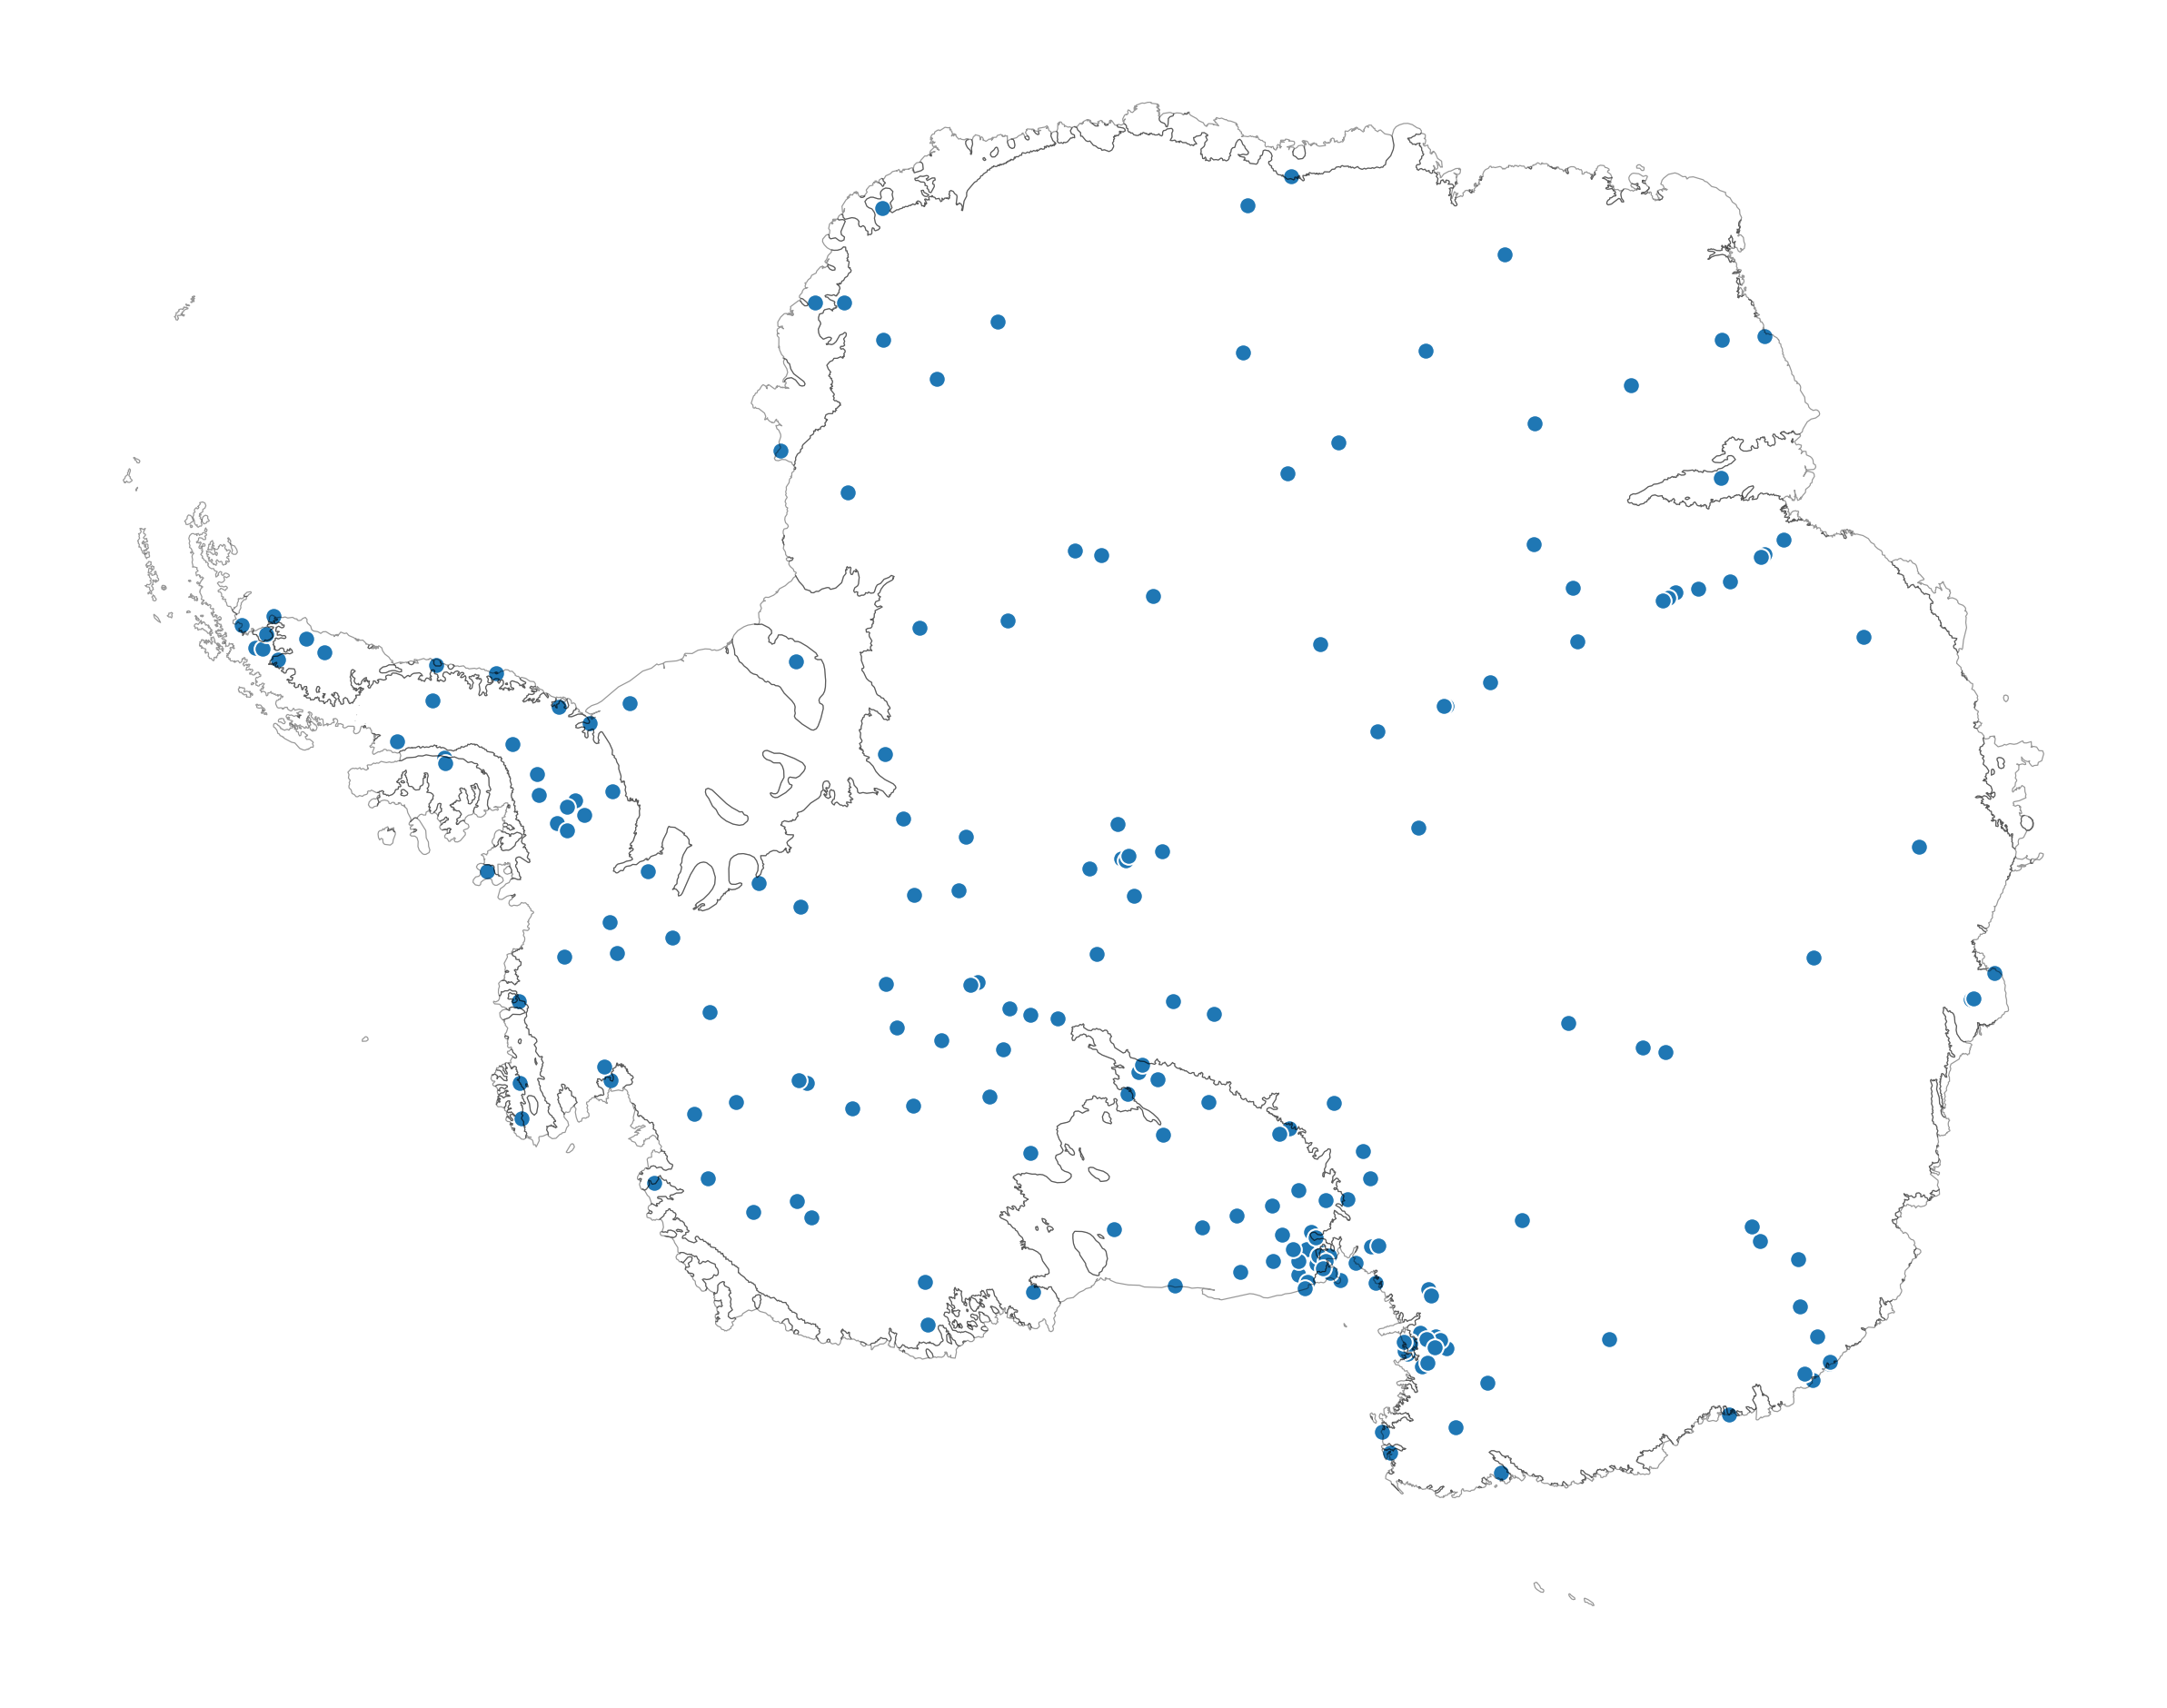

In [ ]:
# Plotting the weather station locations
fig, ax = plt.subplots(1, 1, figsize=(10, 10),dpi=300)#,frameon=False)
background_map_rotatedcoords(ax)
ax.scatter(
    ds_aws.glon,
    ds_aws.glat,
    s=20,
    edgecolor='w',
    linewidths=0.5,
)

In [ ]:
ds_climate_stacked = ds_climate.stack(x=('grid_longitude', 'grid_latitude')).dropna('x')

In [43]:
# Computing Nearest Neighbours
ox = np.dstack([ds_aws['glon'],ds_aws['glat']])[0]
cx = np.dstack([ds_climate_stacked['glon'],ds_climate_stacked['glat']])[0]
nn_indecies = []
for point in ox:
    nn_indecies.append(distance.cdist([point], cx).argmin())
ds_climate_nearest_stacked = ds_climate_stacked.isel(x=nn_indecies)
ds_climate_nearest_stacked = ds_climate_nearest_stacked.assign_coords(nearest_station=("x", ds_aws.station.data))
ds_climate_nearest_stacked = ds_climate_nearest_stacked.swap_dims({"x": "nearest_station"})


In [10]:
print('Weather Station Dataset \n')
ds_aws

Weather Station Dataset 



<xarray.Dataset> Size: 925kB
Dimensions:         (station: 219, t: 504)
Coordinates:
  * station         (station) <U22 19kB 'AGO Site' 'AGO-4' ... 'aws16' 'aws17'
    glat            (station) float64 2kB ...
    glon            (station) float64 2kB ...
    grid_latitude   (station) float64 2kB ...
    grid_longitude  (station) float64 2kB ...
    year            (t) float64 4kB ...
    month           (t) float64 4kB ...
  * t               (t) float64 4kB 1.0 2.0 3.0 4.0 ... 501.0 502.0 503.0 504.0
Data variables:
    latitude        (station) float64 2kB ...
    elevation       (station) float64 2kB ...
    temperature     (station, t) float64 883kB ...

In [23]:
ds_climate

<xarray.Dataset> Size: 45MB
Dimensions:         (time: 456, grid_longitude: 126, grid_latitude: 98)
Coordinates:
  * grid_longitude  (grid_longitude) float64 1kB 152.4 152.9 ... 207.0 207.4
  * grid_latitude   (grid_latitude) float64 784B -21.39 -20.95 ... 20.84 21.29
  * time            (time) datetime64[ns] 4kB 1981-01-31 ... 2018-12-31
    month           (time) int64 4kB ...
    year            (time) int64 4kB ...
    glon            (grid_longitude, grid_latitude) float64 99kB -27.56 ... 2...
    glat            (grid_longitude, grid_latitude) float64 99kB -21.39 ... 2...
    t               (time) int64 4kB ...
Data variables:
    temperature     (time, grid_longitude, grid_latitude) float64 45MB nan .....
    elevation       (grid_longitude, grid_latitude) float64 99kB nan nan ... nan
    latitude        (grid_longitude, grid_latitude) float64 99kB nan nan ... nan

In [28]:
ds_climate_stacked

<xarray.Dataset> Size: 21MB
Dimensions:         (time: 456, x: 5724)
Coordinates:
  * time            (time) datetime64[ns] 4kB 1981-01-31 ... 2018-12-31
    month           (time) int64 4kB 1 2 3 4 5 6 7 8 9 ... 4 5 6 7 8 9 10 11 12
    year            (time) int64 4kB 1981 1981 1981 1981 ... 2018 2018 2018 2018
    glon            (x) float64 46kB -24.92 -24.92 -24.47 ... 23.93 24.36 24.36
    glat            (x) float64 46kB 6.765 7.205 5.885 ... 2.365 1.925 2.365
    t               (time) int64 4kB 13 14 15 16 17 18 ... 464 465 466 467 468
  * x               (x) object 46kB MultiIndex
  * grid_longitude  (x) float64 46kB 155.1 155.1 155.5 ... 203.9 204.4 204.4
  * grid_latitude   (x) float64 46kB 6.765 7.205 5.885 ... 2.365 1.925 2.365
Data variables:
    temperature     (time, x) float64 21MB -4.725 -3.393 -3.771 ... -5.45 -5.065
    elevation       (x) float64 46kB 890.3 684.9 701.0 ... 36.3 22.82 30.78
    latitude        (x) float64 46kB -64.09 -63.97 -64.74 ... -65.52 -65.47

In [4]:
print('Summary of Automatic Weather Station Data \n',
      ds_aws.to_dataframe().describe()[['elevation','latitude','temperature']])
print('\n Summary of Climate Model Data \n',
      ds_climate.to_dataframe().describe()[['elevation','latitude','temperature']])

Summary of Automatic Weather Station Data 
            elevation       latitude   temperature
count  110376.000000  110376.000000  18088.000000
mean     1251.009132     -76.472009    -25.852952
std      1131.183380       5.411963     14.071861
min         5.000000     -90.000000    -71.740000
25%        87.000000     -79.820000    -31.880000
50%      1122.000000     -76.320000    -24.135000
75%      2090.000000     -73.080000    -16.320000
max      4093.000000     -65.240000      1.750000

 Summary of Climate Model Data 
           elevation      latitude   temperature
count  2.610144e+06  2.610144e+06  2.610144e+06
mean   2.003590e+03 -7.661032e+01 -3.257423e+01
std    1.150357e+03  5.392458e+00  1.458319e+01
min   -3.087963e+00 -8.971554e+01 -7.326862e+01
25%    1.045115e+03 -8.060204e+01 -4.373946e+01
50%    2.192235e+03 -7.646343e+01 -3.125523e+01
75%    2.988649e+03 -7.229835e+01 -2.182017e+01
max    4.063502e+03 -6.397399e+01  1.437534e+00


Computing Nearest Neighbours 

In [41]:
ds_climate_nearest_stacked

<xarray.Dataset> Size: 845kB
Dimensions:          (time: 456, nearest_station: 219)
Coordinates:
  * time             (time) datetime64[ns] 4kB 1981-01-31 ... 2018-12-31
    month            (time) int64 4kB ...
    year             (time) int64 4kB ...
    glon             (nearest_station) float64 2kB -7.755 8.085 ... 3.245 -23.16
    glat             (nearest_station) float64 2kB 9.405 0.165 ... 17.32 5.445
    t                (time) int64 4kB ...
    x                (nearest_station) object 2kB MultiIndex
    grid_longitude   (nearest_station) float64 2kB 172.2 188.1 ... 183.2 156.8
    grid_latitude    (nearest_station) float64 2kB 9.405 0.165 ... 17.32 5.445
    nearest_Station  (nearest_station) <U22 19kB 'AGO Site' 'AGO-4' ... 'aws17'
Dimensions without coordinates: nearest_station
Data variables:
    temperature      (time, nearest_station) float64 799kB -10.7 ... -1.061
    elevation        (nearest_station) float64 2kB 1.46e+03 3.528e+03 ... 143.9
    latitude         (nearest_station) float64 2kB -77.42 -81.89 ... -66.12

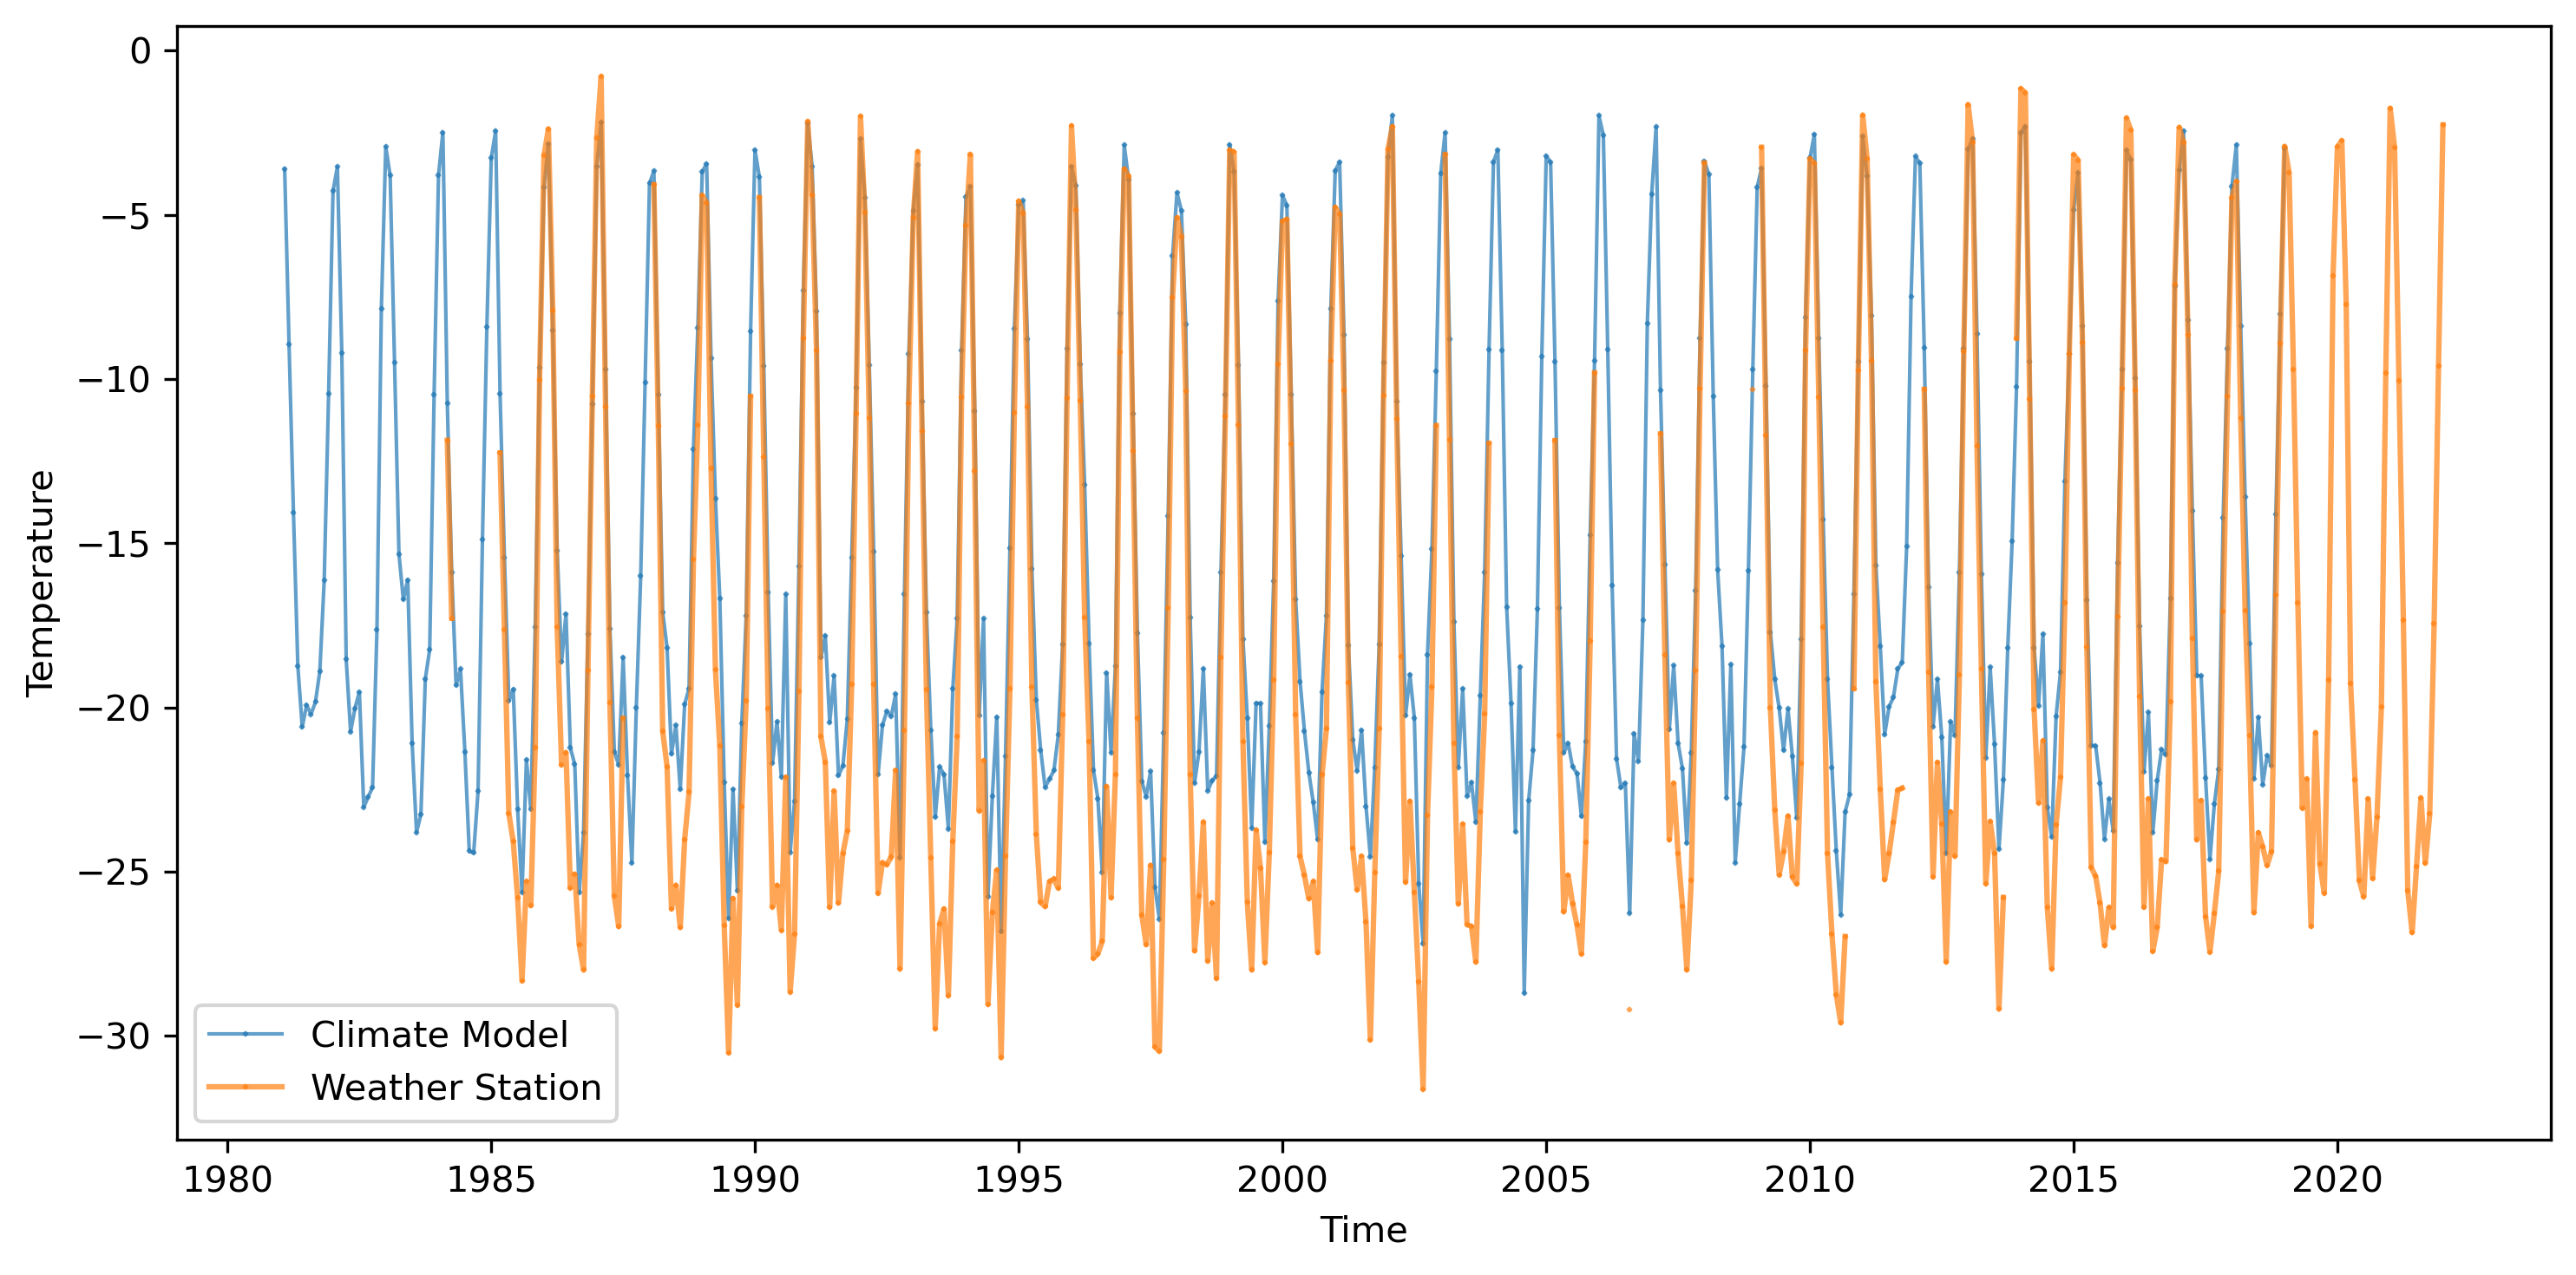

In [46]:
# Single Site Full Time Series

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)

station = 'Manuela'
# station = 'Byrd'

ds_climate_nearest_stacked.sel(nearest_station = station)['temperature'].plot(x="t",
                                                                              ax=ax,
                                                                              hue='station',
                                                                              alpha=0.7,
                                                                              label='Climate Model',
                                                                              marker='x',
                                                                              ms=1,
                                                                              color='tab:blue',
                                                                              linewidth=1.0)

ds_aws.sel(station = station)['temperature'].plot(ax=ax,
                                                hue='station',
                                                alpha=0.7,
                                                label='Weather Station',
                                                marker='x',
                                                ms=1,
                                                color='tab:orange',
                                                linewidth=1.5)

xticks = np.arange(0,45*12,12*5)
xticklabels = np.arange(1980,2025,5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel('Temperature')
ax.set_xlabel('Time')
ax.legend()
ax.set_title('')

plt.tight_layout()
plt.show()

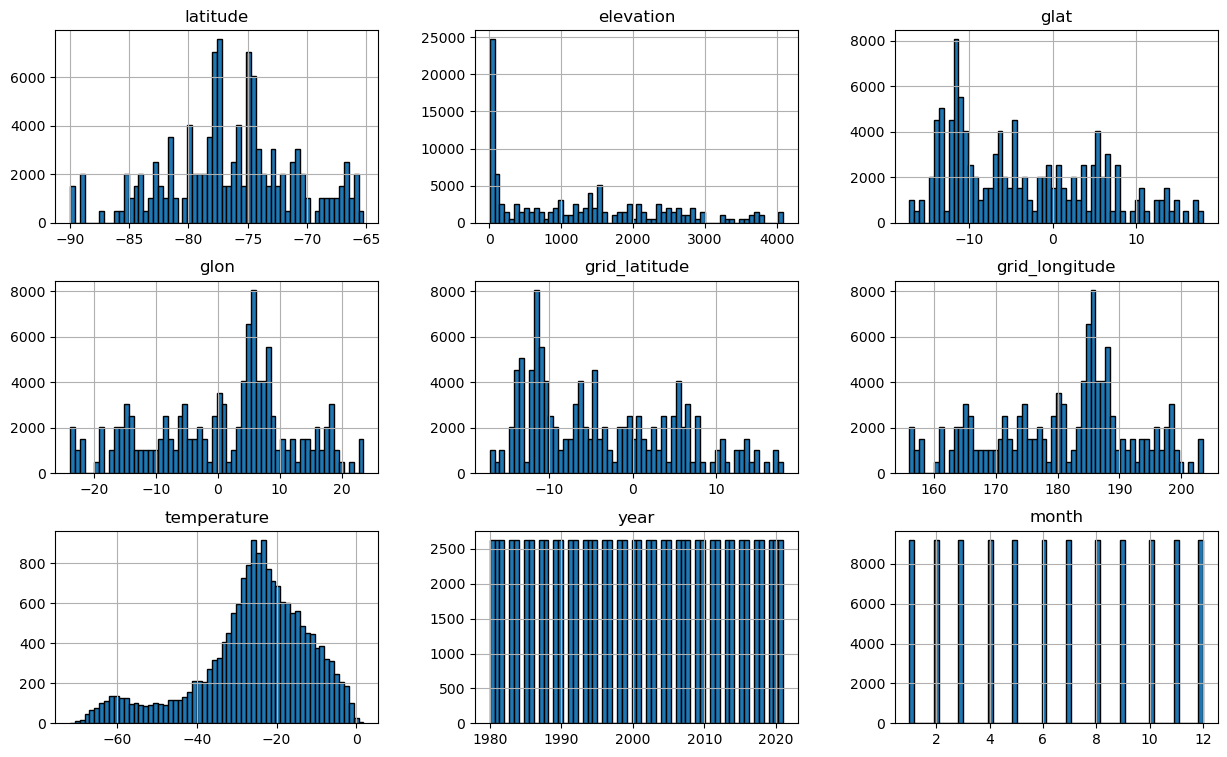

In [35]:
# Marginal Histograms
ds_aws.to_dataframe().hist(bins=60, figsize=(15,9),color='tab:blue',edgecolor='black')
plt.show()

In [ ]:
ds_climate.to_dataframe().describe()

,temperature,elevation,latitude,month,year,glon,glat
count,2.610144e+06,2.610144e+06,2.610144e+06,5.630688e+06,5.630688e+06,5.630688e+06,5.630688e+06
mean,-3.257423e+01,2.003590e+03,-7.661032e+01,6.500000e+00,1.999500e+03,-5.499949e-02,-5.499959e-02
std,1.458319e+01,1.150357e+03,5.392458e+00,3.452053e+00,1.096586e+01,1.600365e+01,1.244702e+01
min,-7.326862e+01,-3.087963e+00,-8.971554e+01,1.000000e+00,1.981000e+03,-2.755500e+01,-2.139500e+01
25%,-4.373946e+01,1.045115e+03,-8.060204e+01,3.750000e+00,1.990000e+03,-1.391500e+01,-1.083500e+01
50%,-3.125523e+01,2.192235e+03,-7.646343e+01,6.500000e+00,1.999500e+03,-5.500031e-02,-5.499959e-02
75%,-2.182017e+01,2.988649e+03,-7.229835e+01,9.250000e+00,2.009000e+03,1.380500e+01,1.072500e+01
max,1.437534e+00,4.063502e+03,-6.397399e+01,1.200000e+01,2.018000e+03,2.744500e+01,2.128500e+01


In [6]:
# Summary Statistics
ds_aws.to_pandas().describe()

ValueError: cannot convert Datasets with 2 dimensions into pandas objects without changing the number of dimensions. Please use Dataset.to_dataframe() instead.